In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [3]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax

import numpy as np

from tqdm.auto import tqdm

from functools import partial

from flax import nnx

/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys 
sys.path.append("examples/sbi-benchmarks")
sys.path.append("src/")

In [5]:
import sbibm
from utils.sbi_tasks import TwoMoons

from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.loss import ContinuousFMLoss

In [6]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()
observation = twomoons.get_observation(1)

theta = prior.sample((10_000,))
xs = simulator(theta)

In [7]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

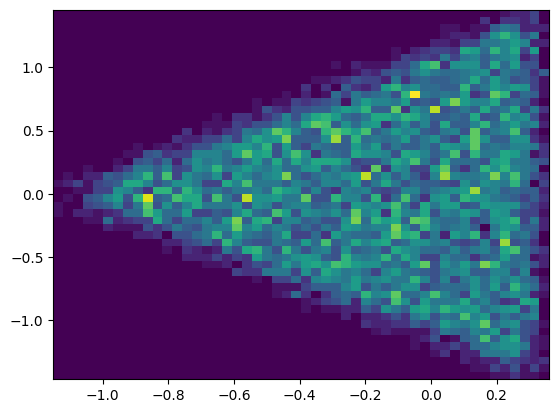

In [8]:
plt.hist2d(xs[:,0],xs[:,1], bins=50, density=True)
plt.show()

In [9]:
from sbibm.algorithms import rej_abc  # See help(rej_abc) for keywords
posterior_samples, _, _ = rej_abc(task=task, num_samples=10_000, num_observation=1, num_simulations=100_000)


Running REJ-ABC
Running 100000 simulations.: 100%|██████████| 100000/100000 [00:00<00:00, 2703787.22it/s]
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  F

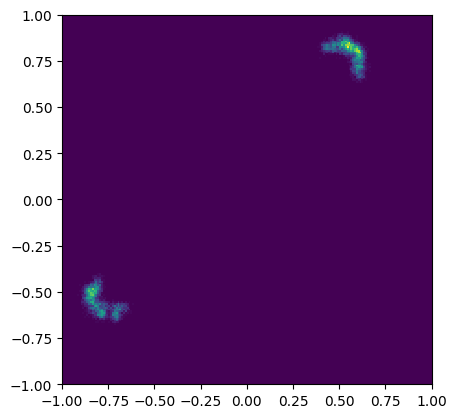

In [10]:
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [11]:
# Once we got samples from an approximate posterior, compare them to the reference:
from sbibm.metrics import c2st
reference_samples = task.get_reference_posterior_samples(num_observation=1)

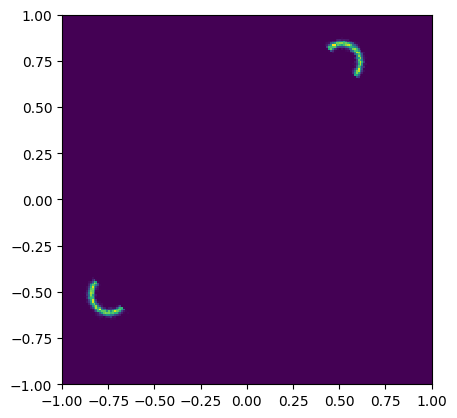

In [12]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [13]:
# c2st_accuracy = c2st(reference_samples, posterior_samples)

In [14]:
# c2st_accuracy # around 0.6

# define the CFM model

In [283]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [284]:
from utils.simformer import Simformer

In [285]:
dim_value = 128     # Size of the value embedding, which is token_dim
dim_id = 20       # Size of the node id embedding
dim_condition = 20  # Size of the condition embedding
num_heads = 5      # Number of attention heads
transformer_features = 10 # Number of features in the transformer

dim_joint = len(twomoons.get_node_id())

In [306]:
vf_model = Simformer(
    dim_value=dim_value,
    dim_id=dim_id,
    dim_condition=dim_condition,
    dim_joint=dim_joint,
    num_heads=num_heads,
    dropout_rate = 0.01,
    transformer_features=transformer_features,
    rngs = nnx.Rngs(0)
)

In [307]:
# make a dataset
nsamples = int(1e4)
theta = prior.sample((nsamples,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)


In [308]:
# make an infinite dataloader that shuffles the data once it finishes cycling it
class InfiniteDataLoader:
    def __init__(self, data, batch_size, *, rngs: nnx.Rngs):
        self.data = data
        self.batch_size = batch_size
        self.index = 0
        self.rngs = rngs

        self.data_mean = jnp.mean(data, axis=0)
        self.data_std = jnp.std(data, axis=0)

        # self.data = self.normalize(self.data)

    def normalize(self, unnormalized_data):
        # Normalize the data to be between 0 mean and unit varainve
        data = unnormalized_data - self.data_mean
        data = data / self.data_std

        return data

    def unnormalize(self, normdata):
        # Unnormalize the data
        data = normdata * self.data_std
        data = data + self.data_mean
        return data

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self._shuffle()
        batch = self.data[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return batch

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        return self.data[index]

    def _shuffle(self):
        self.data = jax.random.permutation(self.rngs.perm(), self.data)
        self.index = 0

In [309]:
batch_size = 1024
dataset = InfiniteDataLoader(data, batch_size, rngs=nnx.Rngs(0))

In [310]:
# make sure the model works
batch = next(dataset)
vf_model(batch, jnp.ones((1,)),node_ids=node_ids, condition_mask=jnp.zeros_like(node_ids)).shape

(1024, 4)

In [311]:
loss_fn_cfm = ContinuousFMLoss(path)

In [312]:
def marginalize(rng: jax.random.PRNGKey, edge_mask: jax.Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

In [313]:
undirected_edge_mask = twomoons.get_edge_mask_fn("undirected")(node_ids, None)
posterior_faithfull = twomoons.get_edge_mask_fn("faithfull")(node_ids, condition_mask=jnp.array([0,0,1,1]))

In [314]:
@partial(jax.jit, static_argnames=["nsamples"])
def get_random_condition_mask(rng: jax.random.PRNGKey, nsamples):
    mask_joint = jnp.zeros((nsamples, dim_joint ), dtype=jnp.bool_)
    # repeat the joint mask 5 times on the first axis
    mask_joint = jnp.repeat(mask_joint, 5, axis=0) # make it more probable
    mask_posterior = jnp.concatenate([jnp.zeros((nsamples, dim_theta), dtype=jnp.bool_), jnp.ones((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    # mask_likelihood = jnp.concatenate([jnp.ones((nsamples, dim_theta), dtype=jnp.bool_), jnp.zeros((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    
    mask1 = jax.random.bernoulli(rng, p=0.3, shape=(nsamples, dim_joint))
    filter = ~jnp.all(mask1, axis=-1)
    mask1 = jnp.logical_and(mask1, filter.reshape(-1,1))

    # masks = jnp.concatenate([mask_joint, mask1, mask_posterior, mask_likelihood], axis=0)
    masks = jnp.concatenate([mask_joint, mask1, mask_posterior], axis=0)
    return  jax.random.choice(rng, masks, shape=(nsamples,), replace=False, axis=0)

# @partial(jax.jit, static_argnames=["nsamples"])
# def get_random_condition_mask(rng: jax.random.PRNGKey, nsamples):
#     mask_joint = jnp.zeros((nsamples, dim_joint ), dtype=jnp.bool_)
#     mask_posterior = jnp.concatenate([jnp.zeros((nsamples, dim_theta), dtype=jnp.bool_), jnp.ones((nsamples, dim_x), dtype=jnp.bool_)], axis=-1)
    
#     masks = jnp.concatenate([mask_joint, mask_posterior], axis=0)
#     return  jax.random.choice(rng, masks, shape=(nsamples,), replace=False, axis=0)
    

In [354]:
from numpyro import distributions as dist

mixing_probs = jnp.array([0.5, 0.5])
mixing_dist = dist.Categorical(probs=mixing_probs)

locs = jnp.array([
    [-1.0, -1.0, 0., 0.],
    [1.0, 1.0, 0., 0.]
])

scales = jnp.ones((2, 4))


batched_normals = dist.Normal(loc=locs, scale=scales)

component_distributions = dist.Independent(batched_normals, reinterpreted_batch_ndims=1)

p0_dist_model = dist.Mixture(mixing_dist, component_distributions)

In [355]:
def loss_fn_(vf_model, key: jax.random.PRNGKey):

    batch_size = dataset.batch_size

    rng_x0, rng_t, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 5)
    
    # Generate data and random times
    x_1 = next(dataset) # n, T_max, 1
    x_0 = p0_dist_model.sample(rng_x0, (batch_size,)) # n, T_max, 1
    # x_0 = jax.random.normal(rng_x0, x_1.shape) 
    
    t = jax.random.uniform(rng_t, x_1.shape[0])

    batch = (x_0, x_1, t)
    
    # Condition mask -> randomly condition on some data. Here you can choose between the different condition masks, and you should specify the conditionals you may want to compute afterwards.
    condition_mask = get_random_condition_mask(rng_condition, batch_size)

    # undirected_edge_mask 
    undirected_edge_mask_ = jnp.repeat(undirected_edge_mask[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # faithfull posterior mask
    faithfull_edge_mask_ = jnp.repeat(posterior_faithfull[None,...], 3*batch_size, axis=0) # Dense default mask
    
    # Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size,)), undirected_edge_mask)
    edge_masks = jnp.concatenate([undirected_edge_mask_, faithfull_edge_mask_, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask


    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = loss_fn_cfm(vf_model, batch, node_ids=node_ids, edge_mask=edge_masks,condition_mask=condition_mask, )

    return loss

In [356]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: loss_fn_(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.
    return loss

In [1]:
vf_model = Simformer(
    dim_value=dim_value,
    dim_id=dim_id,
    dim_condition=dim_condition,
    dim_joint=dim_joint,
    num_heads=num_heads,
    dropout_rate = 0.01,
    transformer_features=transformer_features,
    rngs = nnx.Rngs(0)
)

NameError: name 'Simformer' is not defined

In [357]:
optimizer = nnx.Optimizer(vf_model, optax.adam(1e-4))  
train_step(vf_model, optimizer, nnx.Rngs(0).dist()) # ensure that the model is working and compile the function

Array(0.81138647, dtype=float32)

In [358]:
rngs = nnx.Rngs(0)

In [ ]:
nepochs = 2
# schedule = optax.schedules.exponential_decay(1e-4, 
#                                              1e4, 
#                                              decay_rate = 0.2, 
#                                              transition_begin = 5000, 
#                                              end_value = 1e-6)

# optimizer = nnx.Optimizer(vf_model, optax.adam(schedule))  
optimizer = nnx.Optimizer(vf_model, optax.adam(1e-4)) 


vf_model.train()

for ep in range(nepochs):
    pbar = tqdm(range(10000))
    l = 0
    for j in pbar:
        key_ = rngs.train_step()
        loss = train_step(vf_model, optimizer, key_)
        l += loss.item()
        if j % 10 == 0:
            pbar.set_postfix(loss=f"{l/(10):.4f}")
            l=0
    # print(l)



vf_model.eval()

  0%|          | 0/10000 [00:00<?, ?it/s]

# sample the posterior

In [321]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
observation = jnp.array(twomoons.get_observation(1))

In [ ]:
rng = jax.random.PRNGKey(45)
T = jnp.linspace(0,1,10)  # sample times
step_size = 0.001

nsamples = 100_000 #reference_samples.shape[0]

# x_init = jnp.zeros((nsamples, dim_joint))  # initial conditions
key1,key2 = jax.random.split(rng, 2)
x_init = p0_dist_model.sample(key1, (nsamples,))
# noise = jnp.zeros((batch_size, dim_x)) # n, T_max, 1
# noise = jax.random.normal(key2, (batch_size, dim_x)) # n, T_max, 1
# x_init = jnp.concatenate([samples_prior, noise], axis=-1)


# x_init = jax.random.normal(rng, (nsamples, dim_joint))  # initial conditions
condition_mask = jnp.array([0,0,1,1], dtype=jnp.bool_)  # condition on the data, obtain the 2d posterior


x_init = x_init.at[:, 2].set(observation[0,0]) # set the conditioned values
x_init = x_init.at[:, 3].set(observation[0,1]) # set the conditioned values


solver = ODESolver(velocity_model=vf_model)  # create an ODESolver class
# model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": undirected_edge_mask}
model_extras = {"node_ids": jnp.array([0, 1, 2, 3]), "edge_mask": posterior_faithfull}
sampler_ = solver.get_sampler(time_grid=T, condition_mask=condition_mask, method='dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
samples = sampler_(x_init)  # sample from the model

# samples = dataset.unnormalize(samples)

In [329]:
posterior_samples = samples[:,0:2]

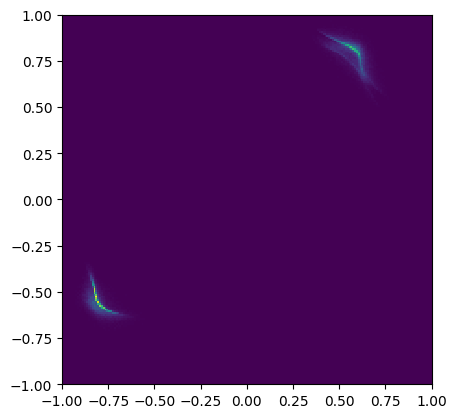

In [330]:
plt.hist2d(posterior_samples[:,0], posterior_samples[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
# same ratio on axis 
# plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

In [331]:
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-1, 1, grid_size), jnp.linspace(-1, 1, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [336]:
x_1.shape

(40000, 2)

In [340]:
observation[0,2]

Array(0.16234657, dtype=float32)

In [ ]:
# get the logprob
logp_sampler = solver.get_unnormalized_logprob(condition_mask=condition_mask, time_grid=[1.0,0.0],method='dopri5', step_size=step_size, log_p0=p0_dist_model.log_prob, model_extras=model_extras)
# create an y_init which has theta on the first position and x1,x2 on the second and third position
y_init = jnp.zeros((x_1.shape[0], 4))
y_init = y_init.at[:,0].set(x_1[:,0])
y_init = y_init.at[:,1].set(x_1[:,1])
y_init = y_init.at[:,2].set(observation[0,0])
y_init = y_init.at[:,3].set(observation[0,1])

_ , exact_log_p = logp_sampler(y_init)
p = jnp.exp(exact_log_p)[-1]
# # # normalize the distribution
# n = jax.scipy.integrate.trapezoid(p, theta)
# p = p/n


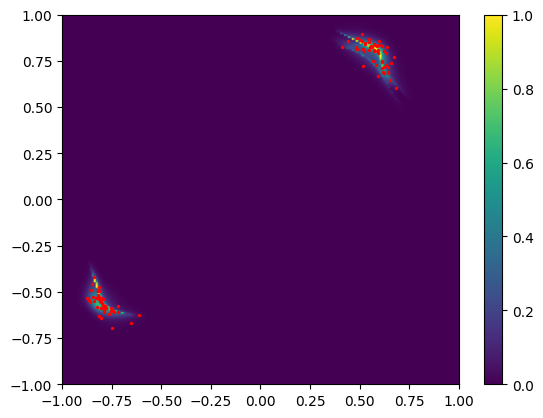

In [353]:
p_grid = p.reshape((grid_size, grid_size))
plt.imshow(p_grid, origin='lower', aspect='auto', extent=(-1, 1, -1, 1), cmap='viridis', vmin=0, vmax=10)
plt.scatter(posterior_samples[:100,0], posterior_samples[:100,1], alpha=1, color='red', s=2)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.colorbar()
plt.show()

In [42]:
# convert posterior samples to a torch array
import torch
posterior_samples_torch = torch.tensor(np.array(posterior_samples))

In [43]:
c2st_accuracy = c2st(reference_samples, posterior_samples_torch)

In [44]:
c2st_accuracy

tensor([0.9091])